In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from ml_logic.preprocessor import data_balancing, create_model, load_and_preprocess_image, image_augmentation


2023-12-05 19:14:40.679239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 19:14:43.435649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-05 19:14:43.435745: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-05 19:14:43.749999: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 19:14:51.916967: W tensorflow/stream_executor/platform/de

In [3]:
# Loading Datasets

train = pd.read_csv('../data/RFMiD_Training_Labels.csv').set_index('ID')
test = pd.read_csv('../data/RFMiD_Testing_Labels.csv').set_index('ID')
eval = pd.read_csv('../data/RFMiD_Validation_Labels.csv').set_index('ID')


In [4]:
# Splitting Data

# X_train = train.drop(columns='Disease_Risk')
X_train = data_balancing(table_link='../data/')
# y_train = train['Disease_Risk']
y_train = X_train
X_eval  = eval.drop(columns='Disease_Risk')
y_eval = eval['Disease_Risk']


In [5]:
print(X_train.sample(5))
print(X_train.shape)
print(y_train.sample(5))
print(y_train.shape)


      Disease_Risk
ID                
904              0
367              1
1543             0
366              1
761              1
(802, 1)
      Disease_Risk
ID                
1795             0
796              1
795              0
165              1
1315             1
(802, 1)


In [6]:
# Loading Images

image_folder = '../data/training_images'
eval_image_folder = '../data/eval_images'
images = np.array([load_and_preprocess_image(row_id, image_folder) for row_id in X_train.index])
eval_images = np.array([load_and_preprocess_image(row_id, eval_image_folder) for row_id in X_eval.index])


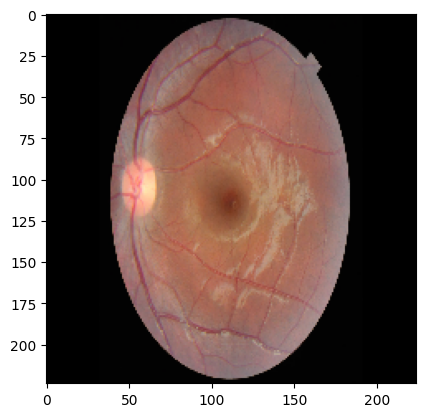

In [7]:
plt.imshow(images[0])


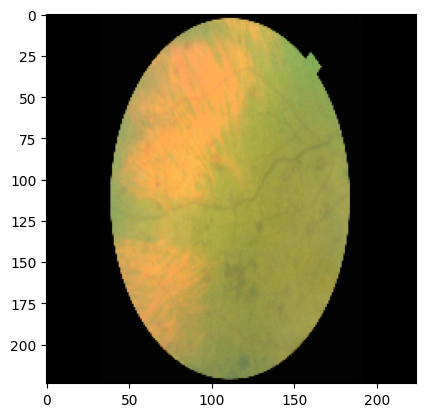

In [8]:
plt.imshow(eval_images[0])


In [9]:
# Augment Images

augmented_images = image_augmentation(images)
augmented_eval_images = image_augmentation(eval_images)


2023-12-05 19:19:07.314235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-05 19:19:07.315675: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-05 19:19:07.319688: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-R72GEULP): /proc/driver/nvidia/version does not exist
2023-12-05 19:19:07.334853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 19:19:07.631554: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 482893824 e

2023-12-05 19:19:18.300921: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 482893824 exceeds 10% of free system memory.


2023-12-05 19:19:23.525166: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 482893824 exceeds 10% of free system memory.


2023-12-05 19:19:35.309240: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 482893824 exceeds 10% of free system memory.


2023-12-05 19:19:45.868887: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 482893824 exceeds 10% of free system memory.


: 

In [ ]:
print(augmented_images.shape)
print(augmented_eval_images.shape)


(802, 224, 224, 3)
(640, 224, 224, 3)


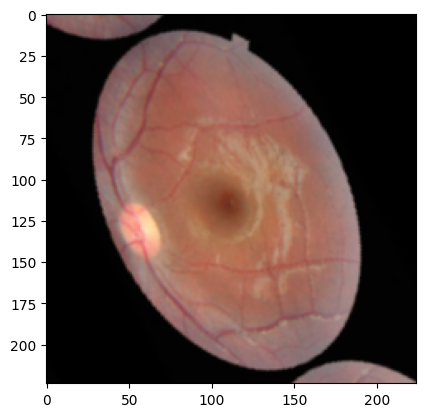

In [ ]:
plt.imshow(augmented_images[0])


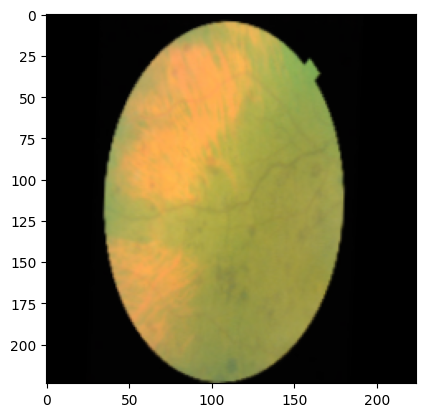

In [ ]:
plt.imshow(augmented_eval_images[0])


In [ ]:
model = create_model((224,224,3))


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 110, 110, 64)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 774400)            0         
                                                                 
 dense_3 (Dense)             (None, 12)                9292812   
                                                           

In [ ]:
early_stopper = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.05,
    patience=10,
)


In [ ]:
model.fit(
    augmented_images, y_train,
    validation_data=(augmented_eval_images, y_eval),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopper]
)


Epoch 1/20
13/13 [==============================] - 48s 4s/step - loss: 0.8441 - accuracy: 0.5087 - val_loss: 0.6625 - val_accuracy: 0.7906
Epoch 2/20
13/13 [==============================] - 48s 4s/step - loss: 0.6871 - accuracy: 0.4900 - val_loss: 0.6860 - val_accuracy: 0.4156
Epoch 3/20
13/13 [==============================] - 49s 4s/step - loss: 0.6804 - accuracy: 0.5661 - val_loss: 0.6663 - val_accuracy: 0.5141
Epoch 4/20
13/13 [==============================] - 47s 4s/step - loss: 0.6495 - accuracy: 0.6496 - val_loss: 0.5682 - val_accuracy: 0.7125
Epoch 5/20
13/13 [==============================] - 48s 4s/step - loss: 0.6369 - accuracy: 0.6409 - val_loss: 0.5740 - val_accuracy: 0.6062
Epoch 6/20
13/13 [==============================] - 48s 4s/step - loss: 0.6179 - accuracy: 0.6671 - val_loss: 0.5899 - val_accuracy: 0.5500
Epoch 7/20
13/13 [==============================] - 61s 5s/step - loss: 0.6445 - accuracy: 0.6147 - val_loss: 0.6131 - val_accuracy: 0.4750
Epoch 8/20
13/13 [==

In [ ]:
model.evaluate(augmented_eval_images, y_eval)


20/20 [==============================] - 7s 338ms/step - loss: 0.6433 - accuracy: 0.4766


[0.643252968788147, 0.4765625]